In [13]:
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.decomposition import PCA

dataset = pd.read_csv("pd_speech_features.csv")
dataset = dataset.drop(['id'],axis=1)
dataset.shape

column_names = list(dataset.columns)
column_names = column_names[:-1]

skewedCols = []
for names in column_names:
    skewVal = dataset[names].skew()
    if(skewVal>1 or skewVal<-1):
        skewedCols.append(names)
# print(skewedCols)
# print(len(skewedCols))

#   Name of the cols containing atleast one negative value
skewedCols_NegativeVals = []
for col_name in skewedCols:
    for values in dataset[col_name]:
        if(values < 0):
            skewedCols_NegativeVals.append(col_name)
            break
# print(len(skewedCols_NegativeVals))

#   Name of the cols containing atleast one zero values
skewedCols_ZeroVals = []
for col_name in skewedCols:
    if col_name in skewedCols_NegativeVals:
        continue
    else:
        for values in dataset[col_name]:
            if(values == 0):
                skewedCols_ZeroVals.append(col_name)
                break
# print(len(skewedCols_ZeroVals))

#   Name of the cols containing only positive values
skewedCols_PositiveVals = []
for col_name in skewedCols:
    if (col_name not in skewedCols_NegativeVals and col_name not in skewedCols_ZeroVals):
        skewedCols_PositiveVals.append(col_name)
# print(len(skewedCols_PositiveVals))

#   Box-Cox Transformation
for col_name in skewedCols_PositiveVals:
    dataset[col_name] = stats.boxcox(dataset[col_name],lmbda=0)

count = 0
for col_name in skewedCols_PositiveVals:
    skewVal = dataset[col_name].skew()
    if skewVal>1 or skewVal<-1:
        count = count + 1
# print(count)
# print(dataset)

#   CubeRoot Transformation on skewedCols_NegativeVals & skewedCols_ZeroVals
for col_name in skewedCols_NegativeVals:
    dataset[col_name] = np.cbrt(dataset[col_name])
for col_name in skewedCols_ZeroVals:
    dataset[col_name] = np.cbrt(dataset[col_name])

count = 0
for col_name in skewedCols_NegativeVals:
    skewVal = dataset[col_name].skew()
    if skewVal>1 or skewVal<-1:
        count = count + 1
# print(count)
# print(dataset)

import statistics
for col_name in column_names:
    qi = dataset[col_name].quantile(0.25)
    qf = dataset[col_name].quantile(0.75)

    iqr = qf - qi
    c = 1.5
    upper_limit=qf+c*iqr
    lower_limit=qi-c*iqr

    col_median = statistics.mean(dataset[col_name].to_numpy())
    for val in dataset[col_name]:
        if val < lower_limit or val > upper_limit:
            dataset[col_name] = dataset[col_name].replace(val,col_median)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# print(dataset)
classes = dataset.iloc[:,-1].values
classes = pd.Series(classes)

dataset_dummy = dataset.iloc[:,:-1]
scaler.fit_transform(dataset_dummy)
dataset_scaled = pd.DataFrame(scaler.transform(dataset_dummy), columns=dataset_dummy.columns)

#print(dataset_scaled.head(5))

pca = PCA(n_components=148)
#train_dataset = pd.DataFrame(pca.fit_transform(dataset_scaled),columns=['c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','c13','c14','c15','c16','c17'])
train_dataset = pd.DataFrame(pca.fit_transform(dataset_scaled))
exp_var = pca.explained_variance_ratio_
#print(exp_var)
#print(train_dataset)
train_dataset.insert(loc=148,column='class',value=classes)
#print(train_dataset)
train_dataset.to_csv('TESTING.csv', index=False)
# dataset_scaled.insert(loc=753,column='class',value=classes)
# print(dataset_scaled)

# dataset_scaled.to_csv('TESTING.csv', index=False)

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.iloc[idx, -1]
        features = torch.tensor(self.data.iloc[idx, :-1].values, dtype=torch.float32)
        return features, label

dataset = CustomDataset('TESTING.csv')


In [15]:
import torchvision.models as models

model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 2)  # 2 classes: 0 or 1


d:\anaconda3\envs\TF3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\TF3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import torch

def tenzor(input,c):
    # Assume your input has shape [batch_size, num_features]
    batch_size = input.size(0)
    if(c==0):
        num_features = input.size(1)
    else:
        num_features = 1
    # Reshape the input to [batch_size, 1, num_features, 1]
    input = torch.reshape(input, (batch_size, 1, num_features, 1))

    # Repeat the input along the channel dimension to create 3 channels
    input = input.repeat(1, 3, 1, 1)

    # Resize the input to 224x224 using interpolation
    input = torch.nn.functional.interpolate(input, size=(224, 224), mode='bilinear', align_corners=False)
    return input

train_dataset, val_dataset = train_test_split(dataset, test_size=0.05, random_state=0)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


val_loader = DataLoader(val_dataset, batch_size=64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 10

# Create lists to store loss and accuracy values
train_loss_values = []
train_acc_values = []

test_dataset = CustomDataset('TESTING.csv')
test_loader = DataLoader(test_dataset, batch_size=32)

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    model.train()
    for features, labels in train_loader:
        optimizer.zero_grad()
        features=tenzor(features,0)
        outputs = model(features)
        # print(outputs,labels)
        # labels=labels.float()
        labels=labels.view(-1)
        # labels=tenzor(labels,0)
        # unique_targets = torch.unique(labels)
        # print(unique_targets)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * features.size(0)
        train_acc += (outputs.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_dataset)
    train_acc /= len(train_dataset)

    # Append loss and accuracy to the lists
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc)

    val_loss = 0
    val_acc = 0
    model.eval()
    # with torch.no_grad():
    #     for features, labels in val_loader:
    #         features=tenzor(features,0)
    #         outputs = model(features)
    #         labels=labels.view(-1)
    #         loss = criterion(outputs, labels)
    #         val_loss += loss.item() * features.size(0)
    #         val_acc += (outputs.argmax(dim=1) == labels).sum().item()
    #     val_loss /= len(val_dataset)
    #     val_acc /= len(val_dataset)

    #print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')


<h3><b>Run This Shit

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import torch

def tenzor(input,c):
    # Assume your input has shape [batch_size, num_features]
    batch_size = input.size(0)
    if(c==0):
        num_features = input.size(1)
    else:
        num_features = 1
    # Reshape the input to [batch_size, 1, num_features, 1]
    input = torch.reshape(input, (batch_size, 1, num_features, 1))

    # Repeat the input along the channel dimension to create 3 channels
    input = input.repeat(1, 3, 1, 1)

    # Resize the input to 224x224 using interpolation
    input = torch.nn.functional.interpolate(input, size=(224, 224), mode='bilinear', align_corners=False)
    return input

train_dataset, val_dataset = train_test_split(dataset, test_size=0.05, random_state=0)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


val_loader = DataLoader(val_dataset, batch_size=64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 10

# Create lists to store loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

test_dataset = CustomDataset('TESTING.csv')
test_loader = DataLoader(test_dataset, batch_size=32)

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    model.train()
    for features, labels in train_loader:
        optimizer.zero_grad()
        features=tenzor(features,0)
        outputs = model(features)
        # print(outputs,labels)
        # labels=labels.float()
        labels=labels.view(-1)
        # labels=tenzor(labels,0)
        # unique_targets = torch.unique(labels)
        # print(unique_targets)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * features.size(0)
        train_acc += (outputs.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_dataset)
    train_acc /= len(train_dataset)

    # Append loss and accuracy to the lists
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc)

    val_loss = 0
    val_acc = 0
    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for features, labels in test_loader:
            features=tenzor(features,0)
            outputs = model(features)
            labels=labels.view(-1)

            predictions = np.argmax(outputs, axis=1)
            # pred.append(predictions)
            # true.append(labels)

            loss = criterion(outputs, labels)
            test_loss += loss.item() * features.size(0)
            test_acc += (outputs.argmax(dim=1) == labels).sum().item()
        test_loss /= len(test_dataset)
        test_acc /= len(test_dataset)  
        test_loss_values.append(test_loss)
        test_acc_values.append(test_acc)
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    #print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')


Test Loss: 18.8262, Test Acc: 0.2540
Epoch 1/10, Train Loss: 0.5546, Train Acc: 0.7591
Test Loss: 0.5298, Test Acc: 0.7434
Epoch 2/10, Train Loss: 0.4097, Train Acc: 0.8078
Test Loss: 1.0931, Test Acc: 0.6892
Epoch 3/10, Train Loss: 0.3037, Train Acc: 0.8760
Test Loss: 0.2298, Test Acc: 0.9167
Epoch 4/10, Train Loss: 0.2194, Train Acc: 0.9067
Test Loss: 0.2821, Test Acc: 0.8704
Epoch 5/10, Train Loss: 0.1886, Train Acc: 0.9234
Test Loss: 0.1206, Test Acc: 0.9537
Epoch 6/10, Train Loss: 0.0845, Train Acc: 0.9721
Test Loss: 0.2033, Test Acc: 0.9378
Epoch 7/10, Train Loss: 0.0813, Train Acc: 0.9735
Test Loss: 0.0893, Test Acc: 0.9709
Epoch 8/10, Train Loss: 0.0930, Train Acc: 0.9582
Test Loss: 0.1795, Test Acc: 0.9365
Epoch 9/10, Train Loss: 0.0543, Train Acc: 0.9819
Test Loss: 0.0624, Test Acc: 0.9762
Epoch 10/10, Train Loss: 0.0819, Train Acc: 0.9735


<h3><b>Classification Report

In [19]:
from sklearn.metrics import classification_report

test_dataset = CustomDataset('TESTING.csv')
test_loader = DataLoader(test_dataset, batch_size=32)

model.eval()
test_loss = 0
test_acc = 0
pred = []
true = []
with torch.no_grad():
    for features, labels in test_loader:
        features=tenzor(features,0)
        outputs = model(features)
        labels=labels.view(-1)

        predictions = np.argmax(outputs, axis=1)
        pred.append(predictions)
        true.append(labels)

        loss = criterion(outputs, labels)
        test_loss += loss.item() * features.size(0)
        test_acc += (outputs.argmax(dim=1) == labels).sum().item()
    test_loss /= len(test_dataset)
    test_acc /= len(test_dataset)    

pred = np.concatenate(pred)
true = np.concatenate(true)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
print(classification_report(true, pred))

Test Loss: 0.0624, Test Acc: 0.9762
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       192
           1       0.98      0.99      0.98       564

    accuracy                           0.98       756
   macro avg       0.97      0.97      0.97       756
weighted avg       0.98      0.98      0.98       756



<h3><b>Train vs Test -> Loss and Acc

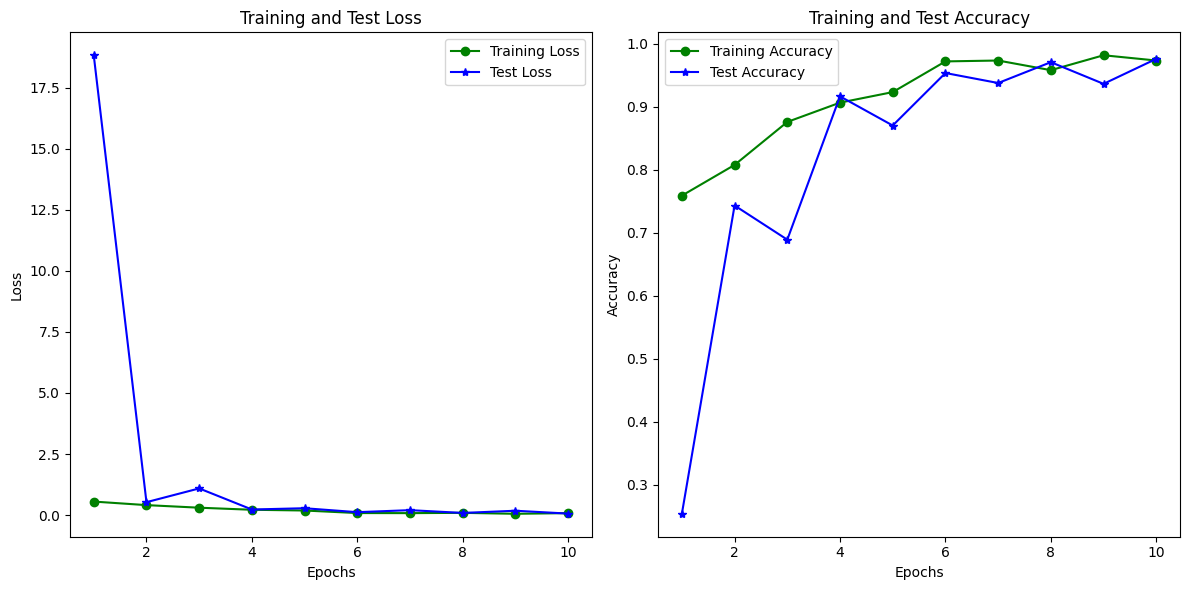

In [18]:
import matplotlib.pyplot as plt

# Assuming the number of epochs is 10
epochs = range(1, 11)

# Create a new figure
plt.figure(figsize=(12, 6))

# Subplot for training and test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, 'go-', label='Training Loss')  # green circles for training loss
plt.plot(epochs, test_loss_values, 'b*-', label='Test Loss')  # blue stars for test loss
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, 'go-', label='Training Accuracy')  # green circles for training accuracy
plt.plot(epochs, test_acc_values, 'b*-', label='Test Accuracy')  # blue stars for test accuracy
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the figure
plt.tight_layout()
plt.show()

<h3><b>AUC-ROC Curve Plot

AUC ROC: 0.9668661347517731


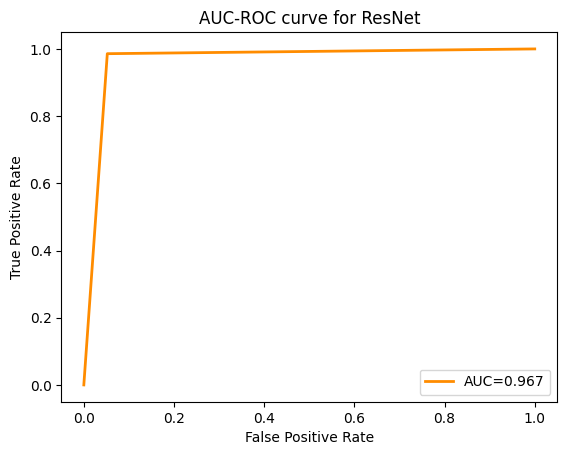

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate predictions for test data
#y_pred = model.predict(train_dataset[0])

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(true, pred)
auc_roc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(dpi=100)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC={auc_roc:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC curve for ResNet')
plt.legend(loc="lower right")

# Calculate area under ROC curve (AUC ROC)
print("AUC ROC:", auc_roc)


AUC ROC: 0.9668661347517731


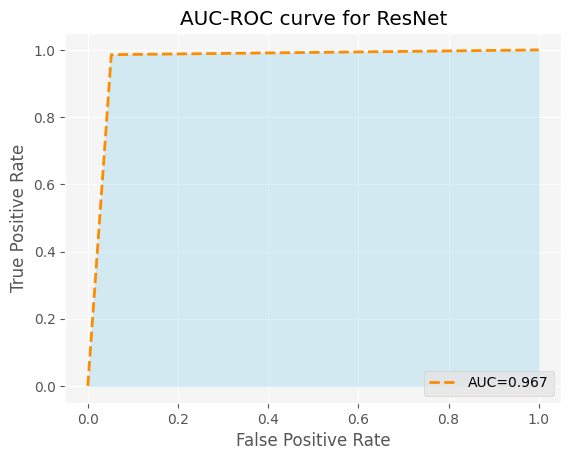

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate predictions for test data
#y_pred = model.predict(train_dataset[0])

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(true, pred)
auc_roc = auc(fpr, tpr)

# Set plot style
plt.style.use('ggplot')

# Plot ROC curve
plt.figure(dpi=100)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC={auc_roc:.3f}', linestyle='--')
plt.fill_between(fpr, tpr, color='skyblue', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC curve for ResNet')
plt.legend(loc="lower right")
plt.grid(True)

# Add a background color
ax = plt.gca()
ax.set_facecolor('whitesmoke')

# Calculate area under ROC curve (AUC ROC)
print("AUC ROC:", auc_roc)

plt.show()

<h3><b>AUC-PR Curve Plot

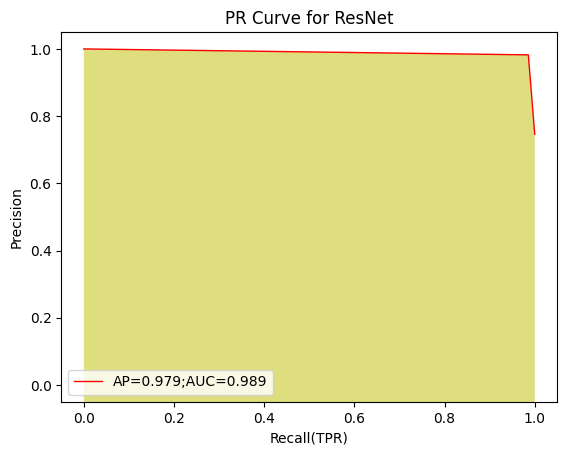

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score,auc
precision,recall,thresholds=precision_recall_curve(true, pred)
avg_precision=average_precision_score(true, pred)
pr_auc=auc(recall,precision)
plt.figure(dpi=100)
plt.plot(recall,precision,lw=1,color='red',label=f'AP={avg_precision:.3f};AUC={pr_auc:.3f}')
plt.fill_between(recall,precision,-1,facecolor='y',alpha=0.5)
plt.title('PR Curve for ResNet')
plt.xlabel('Recall(TPR)')
plt.ylabel('Precision')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()
plt.show()

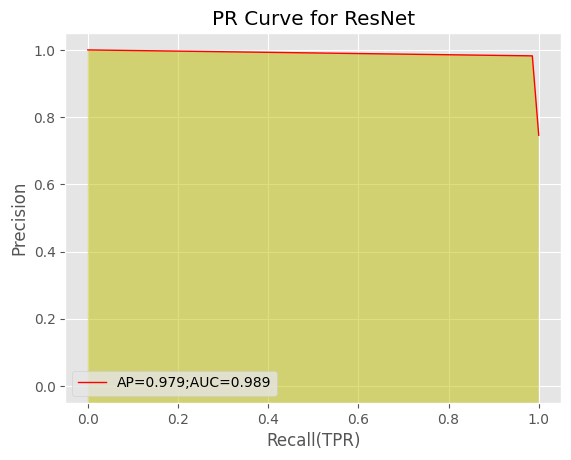

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate predictions for test data
#y_pred = model.predict(train_dataset[0])

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(true, pred)
auc_roc = auc(fpr, tpr)

from sklearn.metrics import precision_recall_curve, average_precision_score,auc
precision,recall,thresholds=precision_recall_curve(true, pred)
avg_precision=average_precision_score(true, pred)
pr_auc=auc(recall,precision)
plt.figure(dpi=100)
plt.plot(recall,precision,lw=1,color='red',label=f'AP={avg_precision:.3f};AUC={pr_auc:.3f}')
plt.fill_between(recall,precision,-1,facecolor='y',alpha=0.5)
plt.title('PR Curve for ResNet')
plt.xlabel('Recall(TPR)')
plt.ylabel('Precision')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()
plt.show()

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split


# Define transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
trainset, val_dataset = train_test_split(dataset, test_size=0.05, random_state=0)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

testset = CustomDataset('TESTING.csv')
testloader = DataLoader(testset, batch_size=32)

# Define ResNet model
net = torchvision.models.resnet18(pretrained=False, num_classes=10)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Train the model and record loss at each epoch
train_loss_list = []
val_loss_list = []

for epoch in range(5):  # loop over the dataset multiple times

    train_loss = 0.0
    net.train()  # set the model to training mode

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # add the batch loss to the total loss for the epoch
        train_loss += loss.item()

    train_loss /= len(trainloader.dataset)
    train_loss_list.append(train_loss)

    # Evaluate the model on validation set
    net.eval()  # set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(testloader.dataset)
    val_loss_list.append(val_loss)

    print('Epoch %d: Train Loss = %.3f, Val Loss = %.3f' %
          (epoch + 1, train_loss, val_loss))

print('Finished Training')
